# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Sanity Functions

In [2]:
def sanity_check(model, use_softplus=False, transformation_grad=1):

    model_dict = dict(model.state_dict())
    print(model_dict.keys())

    if not use_softplus:
        a = model.transformation.params[transformation_grad].detach().cpu()
        eps = torch.empty_like(a)
        eps[0] = a[0]
        eps[1:] = torch.nn.functional.softplus(a[1:])
        eps = torch.cumsum(eps, dim=0)
    
    is_mono = torch.all(torch.diff(eps) > 0)
    print(is_mono.item())
        
    print(f"{eps}")  # should be strictly increasing
    plt.plot(range(len(eps)), eps, marker='o')
    plt.title("Monotonic spline coefficients ε_j,p")
    plt.xlabel("Basis index p")
    plt.ylabel("ε_j,p")
    plt.show()

def series(x):
    """Return a 1D numpy array from tensor OR list/tuple of (tensors|floats)."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    if isinstance(x, (list, tuple)):
        return np.array([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in x])
    return np.asarray(x)

#### Hyperparameter choice

In [3]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    #"RW2": {"tau_a": 1e-3, "tau_b": 1e-3},   # A) nearly-flat proper  ← recommended
    "RW2": {"tau_a": 1.1,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}

# Test 1 ndependence copula + standard Gaussian marginals (N(0,1))

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Independent Copula and add Gaussian marginals.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [ ]:
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)


# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

copula_pv_est = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_26165/815319882.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_26165/815319882.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_26165/815319882.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:
model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4530, grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<06:31,  2.55it/s]

current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4168, grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<01:31, 10.91it/s]

current_loss: tensor(1.5044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4158, grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:00<00:44, 22.36it/s]

current_loss: tensor(1.4158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4351, grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<00:46, 21.17it/s]

current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<01:00, 16.29it/s]

current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:01<00:54, 18.07it/s]

current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152,

  3%|▎         | 28/1000 [00:02<01:10, 13.76it/s]

current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
Early Stop at iteration 28 w

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [7]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=16,            # will ramp
                mcmc_sample_val=64,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.1,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 5,  # try 5–10
                
                #Optimization method
                beta_kl_start= 3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=2000  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:00<03:13,  1.03it/s]

IMPROVED! Congrats
[1/200] ELBO train=10.3649  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-2.06e+04  tau4=0.592764  rank=20  E_qf_mean≈18.7  E_qf_total≈37.4  tau*E_qf≈22.2  target≈22.2  resid≈-2.06e+04  Δ=-1.10e+03   β_KL=3.00  


  1%|          | 2/200 [00:01<02:54,  1.13it/s]

NOT IMPROVED! Nr. 1
[2/200] ELBO train=0.0643  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-24.1  tau4=0.59537  rank=20  E_qf_mean≈18.6  E_qf_total≈37.3  tau*E_qf≈22.2  target≈22.2  resid≈0.0486  Δ=+2.61e-03   β_KL=2.90  


  2%|▏         | 3/200 [00:02<02:45,  1.19it/s]

NOT IMPROVED! Nr. 2
[3/200] ELBO train=0.0653  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-24.1  tau4=0.597828  rank=20  E_qf_mean≈18.6  E_qf_total≈37.1  tau*E_qf≈22.2  target≈22.2  resid≈0.0456  Δ=+2.46e-03   β_KL=2.80  


  2%|▏         | 4/200 [00:03<02:40,  1.22it/s]

NOT IMPROVED! Nr. 3
[4/200] ELBO train=0.0665  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-24  tau4=0.598061  rank=20  E_qf_mean≈18.5  E_qf_total≈37  tau*E_qf≈22.1  target≈22.2  resid≈0.0431  Δ=+2.33e-04   β_KL=2.70  


  2%|▎         | 5/200 [00:04<02:37,  1.24it/s]

NOT IMPROVED! Nr. 4
[5/200] ELBO train=0.0592  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23.9  tau4=0.598489  rank=20  E_qf_mean≈18.4  E_qf_total≈36.9  tau*E_qf≈22.1  target≈22.2  resid≈0.0788  Δ=+4.28e-04   β_KL=2.60  


  3%|▎         | 6/200 [00:04<02:36,  1.24it/s]

NOT IMPROVED! Nr. 5
[6/200] ELBO train=0.0614  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23.7  tau4=0.599105  rank=20  E_qf_mean≈18.4  E_qf_total≈36.7  tau*E_qf≈22  target≈22.2  resid≈0.113  Δ=+6.16e-04   β_KL=2.50  


  4%|▎         | 7/200 [00:05<02:33,  1.25it/s]

NOT IMPROVED! Nr. 6
[7/200] ELBO train=0.0594  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0501 σmin=0.0501 σmax=0.0501  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23.6  tau4=0.599872  rank=20  E_qf_mean≈18.3  E_qf_total≈36.6  tau*E_qf≈21.9  target≈22.2  resid≈0.14  Δ=+7.66e-04   β_KL=2.40  


  4%|▍         | 8/200 [00:06<02:32,  1.26it/s]

NOT IMPROVED! Nr. 7
[8/200] ELBO train=0.0549  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0501 σmin=0.0501 σmax=0.0501  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23.5  tau4=0.600755  rank=20  E_qf_mean≈18.2  E_qf_total≈36.5  tau*E_qf≈21.9  target≈22.2  resid≈0.161  Δ=+8.83e-04   β_KL=2.30  


  4%|▍         | 9/200 [00:07<02:30,  1.27it/s]

NOT IMPROVED! Nr. 8
[9/200] ELBO train=0.0532  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0502 σmin=0.0502 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23.4  tau4=0.601745  rank=20  E_qf_mean≈18.2  E_qf_total≈36.4  tau*E_qf≈21.9  target≈22.2  resid≈0.18  Δ=+9.90e-04   β_KL=2.20  


  5%|▌         | 10/200 [00:08<02:39,  1.19it/s]

NOT IMPROVED! Nr. 9
[10/200] ELBO train=0.0490  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0502 σmin=0.0502 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23.4  tau4=0.602818  rank=20  E_qf_mean≈18.1  E_qf_total≈36.2  tau*E_qf≈21.8  target≈22.2  resid≈0.195  Δ=+1.07e-03   β_KL=2.10  


  6%|▌         | 11/200 [00:09<02:35,  1.21it/s]

NOT IMPROVED! Nr. 10
[11/200] ELBO train=0.0502  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0503 σmin=0.0503 σmax=0.0503  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23.3  tau4=0.60398  rank=20  E_qf_mean≈18.1  E_qf_total≈36.1  tau*E_qf≈21.8  target≈22.2  resid≈0.21  Δ=+1.16e-03   β_KL=2.00  


  6%|▌         | 12/200 [00:09<02:32,  1.23it/s]

NOT IMPROVED! Nr. 11
[12/200] ELBO train=0.0473  val_ELPD=-0.0008  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0503 σmin=0.0503 σmax=0.0503  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23.2  tau4=0.605152  rank=20  E_qf_mean≈18  E_qf_total≈36.1  tau*E_qf≈21.8  target≈22.2  resid≈0.211  Δ=+1.17e-03   β_KL=1.90  


  6%|▋         | 13/200 [00:10<02:29,  1.25it/s]

NOT IMPROVED! Nr. 12
[13/200] ELBO train=0.0455  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0503 σmin=0.0503 σmax=0.0503  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23.2  tau4=0.606331  rank=20  E_qf_mean≈18  E_qf_total≈36  tau*E_qf≈21.8  target≈22.2  resid≈0.212  Δ=+1.18e-03   β_KL=1.80  


  7%|▋         | 14/200 [00:11<02:28,  1.25it/s]

NOT IMPROVED! Nr. 13
[14/200] ELBO train=0.0456  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0504 σmin=0.0504 σmax=0.0504  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23.1  tau4=0.607526  rank=20  E_qf_mean≈18  E_qf_total≈35.9  tau*E_qf≈21.8  target≈22.2  resid≈0.214  Δ=+1.19e-03   β_KL=1.70  


  8%|▊         | 15/200 [00:12<02:36,  1.18it/s]

NOT IMPROVED! Nr. 14
[15/200] ELBO train=0.0399  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0504 σmin=0.0504 σmax=0.0504  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23  tau4=0.608724  rank=20  E_qf_mean≈17.9  E_qf_total≈35.8  tau*E_qf≈21.8  target≈22.2  resid≈0.215  Δ=+1.20e-03   β_KL=1.60  


  8%|▊         | 16/200 [00:13<02:41,  1.14it/s]

NOT IMPROVED! Nr. 15
[16/200] ELBO train=0.0404  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0505 σmin=0.0505 σmax=0.0505  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-23  tau4=0.60994  rank=20  E_qf_mean≈17.9  E_qf_total≈35.8  tau*E_qf≈21.8  target≈22.2  resid≈0.217  Δ=+1.22e-03   β_KL=1.50  


  8%|▊         | 17/200 [00:14<02:35,  1.18it/s]

NOT IMPROVED! Nr. 16
[17/200] ELBO train=0.0399  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0505 σmin=0.0505 σmax=0.0505  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.9  tau4=0.611174  rank=20  E_qf_mean≈17.8  E_qf_total≈35.7  tau*E_qf≈21.8  target≈22.2  resid≈0.22  Δ=+1.23e-03   β_KL=1.40  


  9%|▉         | 18/200 [00:14<02:30,  1.21it/s]

NOT IMPROVED! Nr. 17
[18/200] ELBO train=0.0370  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0505 σmin=0.0505 σmax=0.0505  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.9  tau4=0.61242  rank=20  E_qf_mean≈17.8  E_qf_total≈35.6  tau*E_qf≈21.8  target≈22.2  resid≈0.222  Δ=+1.25e-03   β_KL=1.30  


 10%|▉         | 19/200 [00:15<02:27,  1.23it/s]

NOT IMPROVED! Nr. 18
[19/200] ELBO train=0.0353  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.8  tau4=0.61369  rank=20  E_qf_mean≈17.8  E_qf_total≈35.5  tau*E_qf≈21.8  target≈22.2  resid≈0.225  Δ=+1.27e-03   β_KL=1.20  


 10%|█         | 20/200 [00:16<02:25,  1.24it/s]

NOT IMPROVED! Nr. 19
[20/200] ELBO train=0.0332  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.7  tau4=0.614976  rank=20  E_qf_mean≈17.7  E_qf_total≈35.4  tau*E_qf≈21.8  target≈22.2  resid≈0.228  Δ=+1.29e-03   β_KL=1.10  


 10%|█         | 21/200 [00:17<02:23,  1.25it/s]

NOT IMPROVED! Nr. 20
[21/200] ELBO train=0.0316  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.7  tau4=0.616288  rank=20  E_qf_mean≈17.7  E_qf_total≈35.3  tau*E_qf≈21.8  target≈22.2  resid≈0.232  Δ=+1.31e-03   β_KL=1.00  


 11%|█         | 22/200 [00:17<02:21,  1.26it/s]

NOT IMPROVED! Nr. 21
[22/200] ELBO train=0.0306  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.6  tau4=0.617575  rank=20  E_qf_mean≈17.6  E_qf_total≈35.3  tau*E_qf≈21.8  target≈22.2  resid≈0.227  Δ=+1.29e-03   β_KL=1.00  


 12%|█▏        | 23/200 [00:18<02:20,  1.26it/s]

NOT IMPROVED! Nr. 22
[23/200] ELBO train=0.0317  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.6  tau4=0.618854  rank=20  E_qf_mean≈17.6  E_qf_total≈35.2  tau*E_qf≈21.8  target≈22.2  resid≈0.225  Δ=+1.28e-03   β_KL=1.00  


 12%|█▏        | 24/200 [00:19<02:19,  1.26it/s]

NOT IMPROVED! Nr. 23
[24/200] ELBO train=0.0308  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.6  tau4=0.620118  rank=20  E_qf_mean≈17.6  E_qf_total≈35.2  tau*E_qf≈21.8  target≈22.2  resid≈0.222  Δ=+1.26e-03   β_KL=1.00  


 12%|█▎        | 25/200 [00:20<02:18,  1.26it/s]

NOT IMPROVED! Nr. 24
[25/200] ELBO train=0.0324  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.5  tau4=0.621385  rank=20  E_qf_mean≈17.5  E_qf_total≈35.1  tau*E_qf≈21.8  target≈22.2  resid≈0.222  Δ=+1.27e-03   β_KL=1.00  


 13%|█▎        | 26/200 [00:21<02:18,  1.26it/s]

NOT IMPROVED! Nr. 25
[26/200] ELBO train=0.0297  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.5  tau4=0.622638  rank=20  E_qf_mean≈17.5  E_qf_total≈35  tau*E_qf≈21.8  target≈22.2  resid≈0.219  Δ=+1.25e-03   β_KL=1.00  


 14%|█▎        | 27/200 [00:21<02:17,  1.26it/s]

NOT IMPROVED! Nr. 26
[27/200] ELBO train=0.0316  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.4  tau4=0.6239  rank=20  E_qf_mean≈17.5  E_qf_total≈34.9  tau*E_qf≈21.8  target≈22.2  resid≈0.221  Δ=+1.26e-03   β_KL=1.00  


 14%|█▍        | 28/200 [00:22<02:26,  1.18it/s]

NOT IMPROVED! Nr. 27
[28/200] ELBO train=0.0309  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.4  tau4=0.625158  rank=20  E_qf_mean≈17.4  E_qf_total≈34.9  tau*E_qf≈21.8  target≈22.2  resid≈0.219  Δ=+1.26e-03   β_KL=1.00  


 14%|█▍        | 29/200 [00:23<02:23,  1.19it/s]

NOT IMPROVED! Nr. 28
[29/200] ELBO train=0.0301  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.3  tau4=0.626417  rank=20  E_qf_mean≈17.4  E_qf_total≈34.8  tau*E_qf≈21.8  target≈22.2  resid≈0.219  Δ=+1.26e-03   β_KL=1.00  


 15%|█▌        | 30/200 [00:24<02:23,  1.18it/s]

NOT IMPROVED! Nr. 29
[30/200] ELBO train=0.0309  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.003429999999999999, 0.000343]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.3  tau4=0.627688  rank=20  E_qf_mean≈17.4  E_qf_total≈34.7  tau*E_qf≈21.8  target≈22.2  resid≈0.221  Δ=+1.27e-03   β_KL=1.00  


 15%|█▌        | 30/200 [00:25<02:24,  1.18it/s]

NOT IMPROVED! Nr. 30
[31/200] ELBO train=0.0310  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.003429999999999999, 0.000343]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈-22.2  tau4=0.628968  rank=20  E_qf_mean≈17.3  E_qf_total≈34.7  tau*E_qf≈21.8  target≈22.2  resid≈0.222  Δ=+1.28e-03   β_KL=1.00  
Early stop @ epoch 31: no val improvement for 30 epochs.


In [8]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.1204,   1.5402,   1.5402,   1.5402,   1.6249,   1.6429,   2.4138,
          1.8524,   1.6344,   1.6418,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True)
12
12
Parameter containing:
tensor([-10.2189,   1.4595,   1.4595,   1.4595,   1.5589,   2.3506,   1.8547,
          2.5009,   1.6724,   1.6414,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True)
12
12


FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.1204,  -8.3860,  -6.6516,  -4.9173,  -3.1126,  -1.2929,   1.2067,
          3.2048,   5.0174,   6.8361,   8.6543,  10.4725])


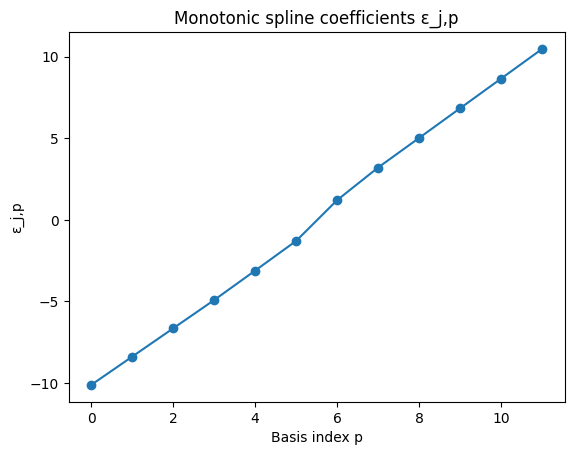

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9900, -8.1802, -6.3536, -4.5438, -2.7340, -0.9242,  0.8856,  2.6954,
         4.5052,  6.3151,  8.1249,  9.9347])


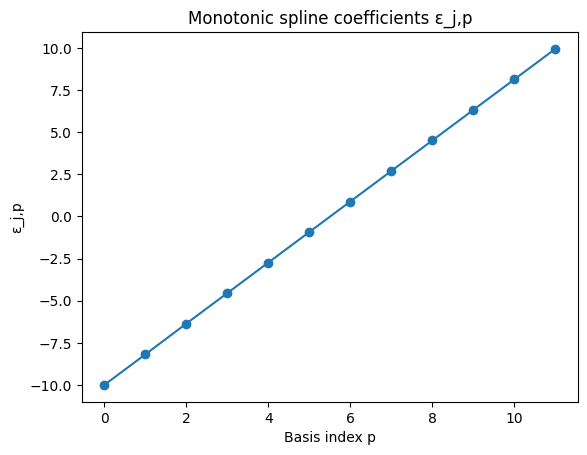

FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.2189,  -8.5505,  -6.8820,  -5.2136,  -3.4638,  -1.0222,   0.9779,
          3.5576,   5.4021,   7.2206,   9.0388,  10.8570])


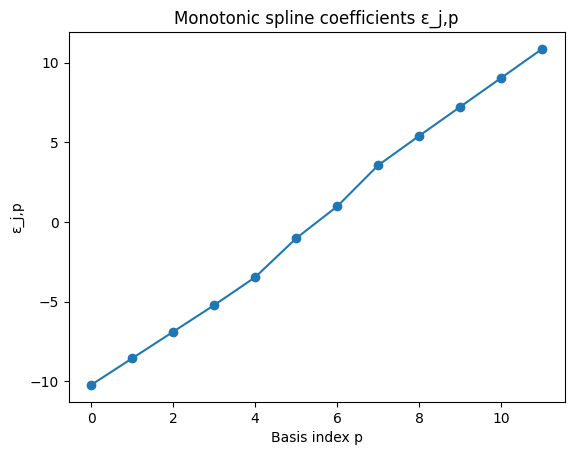

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9900, -8.1802, -6.3536, -4.5438, -2.7340, -0.9242,  0.8856,  2.6954,
         4.5052,  6.3151,  8.1249,  9.9347])


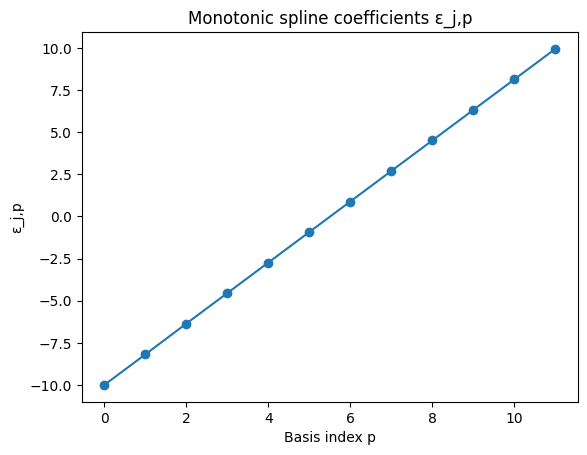

In [9]:
print("FREQ")
sanity_check(model_freq, transformation_grad=0)
print("BAY")
sanity_check(model, transformation_grad=0)
print("FREQ")
sanity_check(model_freq, transformation_grad=1)
print("BAY")
sanity_check(model, transformation_grad=1)

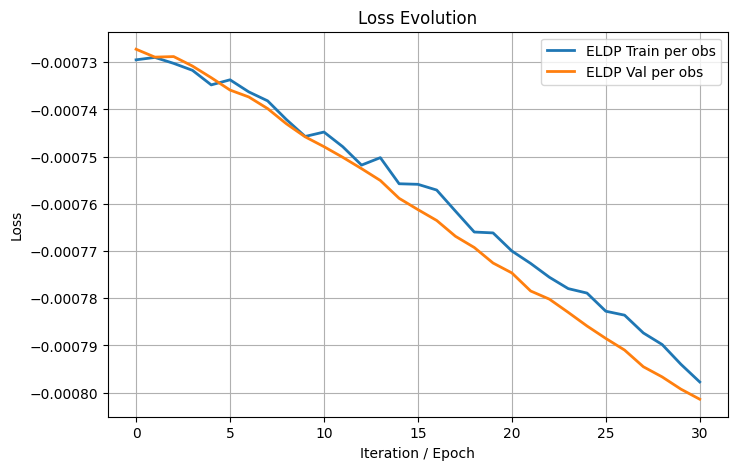

In [10]:
elbo= output['loss_history']
loss_history = output['ll_history']
val_loss = output['val_history']
mean_log_q = output['mean_log_q']
mean_log_p_tilde = output['mean_log_p_tilde']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(mean_log_q, label= "mean_log_q per obs")
#plt.plot(mean_log_p_tilde, label= "mean_log_p_tilde per obs")
#plt.plot(elbo, label= "ELBO per obs")
plt.plot(loss_history, label="ELDP Train per obs", linewidth=2)
plt.plot(val_loss, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(
    "freq_model nr. parameters", sum(p.numel() for p in model_freq.parameters() if p.requires_grad),
    "bay_model nr. parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

print("VI Model params = ",output['mu'])
print("BGTM params = ",[p for p in model.parameters() if p.requires_grad])
print("GTMp params = ",[p for p in model_freq.parameters() if p.requires_grad])

freq_model nr. parameters 24 bay_model nr. parameters 24
VI Model params =  tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311, -9.9900,  1.6311,  1.6511,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311],
       device='cuda:0')
BGTM params =  [Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True)]
GTMp params =  [Parameter containing:
tensor([-10.1204,   1.5402,   1.5402,   1.5402,   1.6249,   1.6429,   2.4138,
          1.8524,   1.6344,   1.6418,   1.6411,   1.6411], requires_grad=True), Parameter containing:
tensor([-10.2189,   1.4595,   1.4595,   1

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0749
KLD GTM      Train Data:  -0.0035
KLD Gaussian Train Data:  -0.0012
KLD Copula   Train Data:  -0.0005

KLD BGTM      Test  Data:  0.0761
KLD GTM      Test  Data:  0.0035
KLD Gaussian Test  Data:  0.0019
KLD Copula   Test  Data:  0.0021


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [15]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

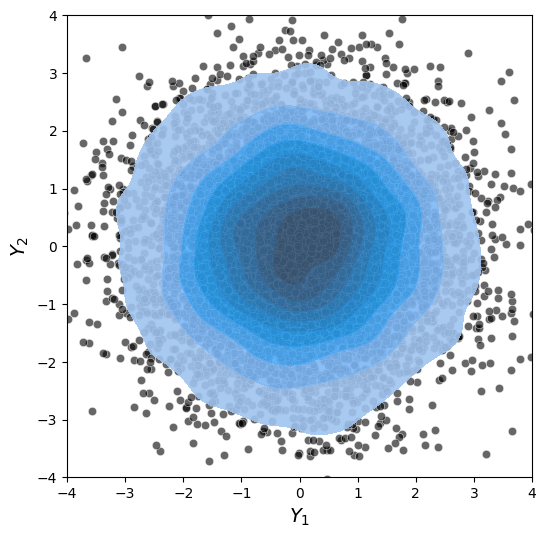

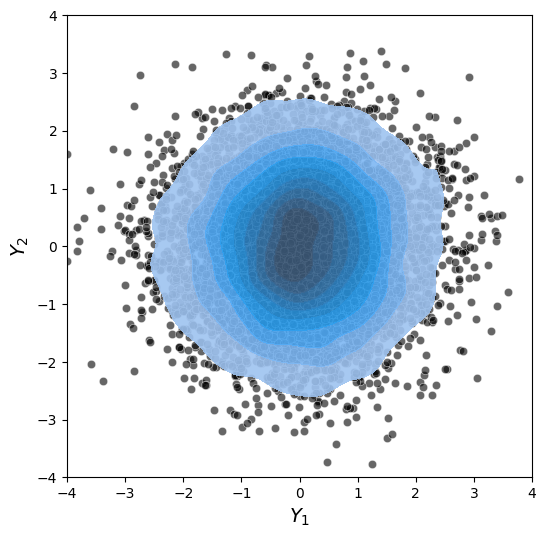

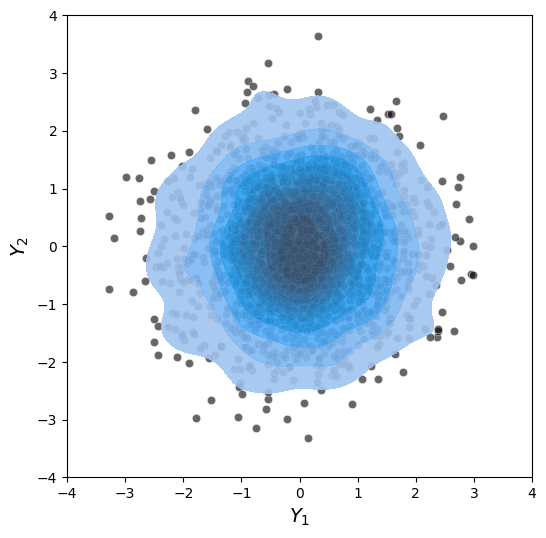

In [16]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

# Test 2
Independence copula + shifted/scaled Gaussian marginals (N(μ, σ²))

In [17]:
# User-chosen marginal parameters
mu = torch.tensor([1.5, -0.7], dtype=torch.float32)
sigma = torch.tensor([1.8, 0.6], dtype=torch.float32)  # stds

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
# Transform uniforms to shifted/scaled Gaussians
Z_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()
simulated_data_train = mu + sigma * Z_train

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
Z_val = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()
simulated_data_validate = mu + sigma * Z_val

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
Z_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()
simulated_data_test = mu + sigma * Z_test

# ---------- "True" log-likelihoods under independence + N(mu, sigma^2) ----------
loglik_true_train = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_train).sum(1)
loglik_true_validate = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_validate).sum(1)
loglik_true_test = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_test).sum(1)

# ---------- "Estimated" marginals from train (fit μ, σ from train) ----------
means = simulated_data_train.mean(0)
stds  = simulated_data_train.std(0, unbiased=True)

loglik_true_est_train = torch.distributions.Normal(means, stds).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means, stds).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means, stds).log_prob(simulated_data_test).sum(1)

# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=300)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=300)

### BGTM model

In [18]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 10,  # try 5–10
                #Optimization method
                beta_kl_start= 1.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 15,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=300  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:01<04:40,  1.41s/it]

IMPROVED! Congrats
[1/200] ELBO train=71.4187  val_ELPD=-0.0070  train_ELPD=-0.0074  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-2.03e+04  tau4=0.600812  rank=20  E_qf_mean≈18.5  E_qf_total≈36.9  tau*E_qf≈22.2  target≈22.2  resid≈-2.03e+04  Δ=-1.10e+03   β_KL=1.50  


  1%|          | 2/200 [00:02<04:39,  1.41s/it]

IMPROVED! Congrats
[2/200] ELBO train=0.3242  val_ELPD=-0.0065  train_ELPD=-0.0069  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-23.7  tau4=0.618126  rank=20  E_qf_mean≈18  E_qf_total≈35.9  tau*E_qf≈22.2  target≈22.2  resid≈0.311  Δ=+1.73e-02   β_KL=1.47  


  2%|▏         | 3/200 [00:04<04:34,  1.40s/it]

IMPROVED! Congrats
[3/200] ELBO train=0.3219  val_ELPD=-0.0060  train_ELPD=-0.0063  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-23.4  tau4=0.628755  rank=20  E_qf_mean≈17.7  E_qf_total≈35.3  tau*E_qf≈22.2  target≈22.2  resid≈0.188  Δ=+1.06e-02   β_KL=1.43  


  2%|▏         | 4/200 [00:05<04:31,  1.38s/it]

IMPROVED! Congrats
[4/200] ELBO train=0.3127  val_ELPD=-0.0057  train_ELPD=-0.0059  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-22.9  tau4=0.629561  rank=20  E_qf_mean≈17.4  E_qf_total≈34.9  tau*E_qf≈21.9  target≈22.2  resid≈0.141  Δ=+8.06e-04   β_KL=1.40  


  2%|▎         | 5/200 [00:06<04:28,  1.38s/it]

IMPROVED! Congrats
[5/200] ELBO train=0.2942  val_ELPD=-0.0057  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-22.1  tau4=0.631218  rank=20  E_qf_mean≈17.2  E_qf_total≈34.4  tau*E_qf≈21.7  target≈22.2  resid≈0.285  Δ=+1.66e-03   β_KL=1.37  


  3%|▎         | 6/200 [00:08<04:26,  1.38s/it]

NOT IMPROVED! Nr. 1
[6/200] ELBO train=0.2923  val_ELPD=-0.0057  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-21.3  tau4=0.633983  rank=20  E_qf_mean≈16.8  E_qf_total≈33.7  tau*E_qf≈21.4  target≈22.2  resid≈0.466  Δ=+2.77e-03   β_KL=1.33  


  4%|▎         | 7/200 [00:09<04:28,  1.39s/it]

IMPROVED! Congrats
[7/200] ELBO train=0.2893  val_ELPD=-0.0056  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-20.6  tau4=0.638061  rank=20  E_qf_mean≈16.4  E_qf_total≈32.9  tau*E_qf≈21  target≈22.2  resid≈0.671  Δ=+4.08e-03   β_KL=1.30  


  4%|▍         | 8/200 [00:11<04:25,  1.38s/it]

IMPROVED! Congrats
[8/200] ELBO train=0.2750  val_ELPD=-0.0056  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-19.9  tau4=0.643536  rank=20  E_qf_mean≈16  E_qf_total≈32  tau*E_qf≈20.6  target≈22.2  resid≈0.877  Δ=+5.47e-03   β_KL=1.27  


  4%|▍         | 9/200 [00:12<04:22,  1.38s/it]

IMPROVED! Congrats
[9/200] ELBO train=0.2770  val_ELPD=-0.0055  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-19.2  tau4=0.657278  rank=20  E_qf_mean≈15.6  E_qf_total≈31.2  tau*E_qf≈20.5  target≈22.2  resid≈1.07  Δ=+1.37e-02   β_KL=1.23  


  5%|▌         | 10/200 [00:13<04:24,  1.39s/it]

IMPROVED! Congrats
[10/200] ELBO train=0.2686  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-18.7  tau4=0.672292  rank=20  E_qf_mean≈15.2  E_qf_total≈30.3  tau*E_qf≈20.4  target≈22.2  resid≈1.14  Δ=+1.50e-02   β_KL=1.20  


  6%|▌         | 11/200 [00:15<04:21,  1.38s/it]

IMPROVED! Congrats
[11/200] ELBO train=0.2477  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0517 σmin=0.0517 σmax=0.0517  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-18.1  tau4=0.688385  rank=20  E_qf_mean≈14.7  E_qf_total≈29.5  tau*E_qf≈20.3  target≈22.2  resid≈1.19  Δ=+1.61e-02   β_KL=1.17  


  6%|▌         | 12/200 [00:16<04:19,  1.38s/it]

IMPROVED! Congrats
[12/200] ELBO train=0.2457  val_ELPD=-0.0054  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0535 σmin=0.0535 σmax=0.0535  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-17.6  tau4=0.705202  rank=20  E_qf_mean≈14.4  E_qf_total≈28.7  tau*E_qf≈20.3  target≈22.2  resid≈1.21  Δ=+1.68e-02   β_KL=1.13  


  6%|▋         | 13/200 [00:17<04:16,  1.37s/it]

NOT IMPROVED! Nr. 1
[13/200] ELBO train=0.2364  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0554 σmin=0.0554 σmax=0.0554  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-17.1  tau4=0.722546  rank=20  E_qf_mean≈14  E_qf_total≈28  tau*E_qf≈20.3  target≈22.2  resid≈1.22  Δ=+1.73e-02   β_KL=1.10  


  7%|▋         | 14/200 [00:19<04:15,  1.37s/it]

IMPROVED! Congrats
[14/200] ELBO train=0.2267  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0573 σmin=0.0573 σmax=0.0573  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-16.6  tau4=0.740454  rank=20  E_qf_mean≈13.7  E_qf_total≈27.3  tau*E_qf≈20.2  target≈22.2  resid≈1.22  Δ=+1.79e-02   β_KL=1.07  


  8%|▊         | 15/200 [00:20<04:13,  1.37s/it]

NOT IMPROVED! Nr. 1
[15/200] ELBO train=0.2230  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0592 σmin=0.0592 σmax=0.0592  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-16  tau4=0.759126  rank=20  E_qf_mean≈13.3  E_qf_total≈26.6  tau*E_qf≈20.2  target≈22.2  resid≈1.24  Δ=+1.87e-02   β_KL=1.03  


  8%|▊         | 16/200 [00:22<04:11,  1.37s/it]

IMPROVED! Congrats
[16/200] ELBO train=0.2077  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0612 σmin=0.0612 σmax=0.0612  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-15.5  tau4=0.778691  rank=20  E_qf_mean≈13  E_qf_total≈25.9  tau*E_qf≈20.2  target≈22.2  resid≈1.27  Δ=+1.96e-02   β_KL=1.00  


  8%|▊         | 17/200 [00:23<04:09,  1.36s/it]

NOT IMPROVED! Nr. 1
[17/200] ELBO train=0.2039  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0633 σmin=0.0632 σmax=0.0633  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-14.9  tau4=0.799357  rank=20  E_qf_mean≈12.6  E_qf_total≈25.2  tau*E_qf≈20.1  target≈22.2  resid≈1.3  Δ=+2.07e-02   β_KL=1.00  


  9%|▉         | 18/200 [00:24<04:08,  1.36s/it]

NOT IMPROVED! Nr. 2
[18/200] ELBO train=0.2014  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0654 σmin=0.0653 σmax=0.0654  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-14.3  tau4=0.821247  rank=20  E_qf_mean≈12.2  E_qf_total≈24.4  tau*E_qf≈20.1  target≈22.2  resid≈1.34  Δ=+2.19e-02   β_KL=1.00  


 10%|▉         | 19/200 [00:26<04:07,  1.37s/it]

NOT IMPROVED! Nr. 3
[19/200] ELBO train=0.1940  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0676 σmin=0.0675 σmax=0.0676  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-13.7  tau4=0.844426  rank=20  E_qf_mean≈11.8  E_qf_total≈23.7  tau*E_qf≈20  target≈22.2  resid≈1.37  Δ=+2.32e-02   β_KL=1.00  


 10%|█         | 20/200 [00:27<04:05,  1.37s/it]

NOT IMPROVED! Nr. 4
[20/200] ELBO train=0.1869  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0698 σmin=0.0697 σmax=0.0698  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-13  tau4=0.86891  rank=20  E_qf_mean≈11.5  E_qf_total≈23  tau*E_qf≈19.9  target≈22.2  resid≈1.41  Δ=+2.45e-02   β_KL=1.00  


 10%|█         | 21/200 [00:28<04:04,  1.37s/it]

NOT IMPROVED! Nr. 5
[21/200] ELBO train=0.1864  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0721 σmin=0.0720 σmax=0.0722  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-12.3  tau4=0.894915  rank=20  E_qf_mean≈11.1  E_qf_total≈22.2  tau*E_qf≈19.9  target≈22.2  resid≈1.44  Δ=+2.60e-02   β_KL=1.00  


 11%|█         | 22/200 [00:30<04:03,  1.37s/it]

NOT IMPROVED! Nr. 6
[22/200] ELBO train=0.1786  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0745 σmin=0.0744 σmax=0.0745  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-11.7  tau4=0.92247  rank=20  E_qf_mean≈10.7  E_qf_total≈21.5  tau*E_qf≈19.8  target≈22.2  resid≈1.48  Δ=+2.76e-02   β_KL=1.00  


 12%|█▏        | 23/200 [00:31<04:01,  1.37s/it]

NOT IMPROVED! Nr. 7
[23/200] ELBO train=0.1772  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0769 σmin=0.0768 σmax=0.0770  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-11  tau4=0.951696  rank=20  E_qf_mean≈10.4  E_qf_total≈20.8  tau*E_qf≈19.8  target≈22.2  resid≈1.52  Δ=+2.92e-02   β_KL=1.00  


 12%|█▏        | 24/200 [00:32<04:00,  1.37s/it]

NOT IMPROVED! Nr. 8
[24/200] ELBO train=0.1732  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0794 σmin=0.0793 σmax=0.0795  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-10.3  tau4=0.982691  rank=20  E_qf_mean≈10  E_qf_total≈20.1  tau*E_qf≈19.7  target≈22.2  resid≈1.55  Δ=+3.10e-02   β_KL=1.00  


 12%|█▎        | 25/200 [00:34<03:58,  1.36s/it]

NOT IMPROVED! Nr. 9
[25/200] ELBO train=0.1650  val_ELPD=-0.0054  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0820 σmin=0.0819 σmax=0.0821  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-9.54  tau4=1.0154  rank=20  E_qf_mean≈9.68  E_qf_total≈19.4  tau*E_qf≈19.7  target≈22.2  resid≈1.58  Δ=+3.27e-02   β_KL=1.00  


 13%|█▎        | 26/200 [00:35<03:57,  1.36s/it]

NOT IMPROVED! Nr. 10
[26/200] ELBO train=0.1588  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0839 σmin=0.0838 σmax=0.0840  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-8.94  tau4=1.04897  rank=20  E_qf_mean≈9.38  E_qf_total≈18.8  tau*E_qf≈19.7  target≈22.2  resid≈1.57  Δ=+3.36e-02   β_KL=1.00  


 14%|█▎        | 27/200 [00:37<03:56,  1.37s/it]

NOT IMPROVED! Nr. 11
[27/200] ELBO train=0.1607  val_ELPD=-0.0055  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0858 σmin=0.0856 σmax=0.0858  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-8.51  tau4=1.08219  rank=20  E_qf_mean≈9.13  E_qf_total≈18.3  tau*E_qf≈19.8  target≈22.2  resid≈1.52  Δ=+3.32e-02   β_KL=1.00  


 14%|█▍        | 28/200 [00:38<03:56,  1.37s/it]

NOT IMPROVED! Nr. 12
[28/200] ELBO train=0.1559  val_ELPD=-0.0055  train_ELPD=-0.0054  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0877 σmin=0.0875 σmax=0.0878  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-8.06  tau4=1.11516  rank=20  E_qf_mean≈8.9  E_qf_total≈17.8  tau*E_qf≈19.9  target≈22.2  resid≈1.47  Δ=+3.30e-02   β_KL=1.00  


 14%|█▍        | 29/200 [00:39<03:54,  1.37s/it]

NOT IMPROVED! Nr. 13
[29/200] ELBO train=0.1557  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0897 σmin=0.0895 σmax=0.0897  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-7.58  tau4=1.14856  rank=20  E_qf_mean≈8.66  E_qf_total≈17.3  tau*E_qf≈19.9  target≈22.2  resid≈1.45  Δ=+3.34e-02   β_KL=1.00  


 15%|█▌        | 30/200 [00:41<03:52,  1.37s/it]

NOT IMPROVED! Nr. 14
[30/200] ELBO train=0.1497  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0917 σmin=0.0915 σmax=0.0918  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-7.1  tau4=1.1823  rank=20  E_qf_mean≈8.43  E_qf_total≈16.9  tau*E_qf≈19.9  target≈22.2  resid≈1.42  Δ=+3.37e-02   β_KL=1.00  


 16%|█▌        | 31/200 [00:42<03:54,  1.39s/it]

NOT IMPROVED! Nr. 15
[31/200] ELBO train=0.1452  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0937 σmin=0.0935 σmax=0.0938  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-6.59  tau4=1.21685  rank=20  E_qf_mean≈8.19  E_qf_total≈16.4  tau*E_qf≈19.9  target≈22.2  resid≈1.42  Δ=+3.46e-02   β_KL=1.00  


 16%|█▌        | 32/200 [00:44<03:53,  1.39s/it]

NOT IMPROVED! Nr. 16
[32/200] ELBO train=0.1393  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0958 σmin=0.0955 σmax=0.0959  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-6.08  tau4=1.25229  rank=20  E_qf_mean≈7.96  E_qf_total≈15.9  tau*E_qf≈19.9  target≈22.2  resid≈1.41  Δ=+3.54e-02   β_KL=1.00  


 16%|█▋        | 33/200 [00:45<03:54,  1.40s/it]

NOT IMPROVED! Nr. 17
[33/200] ELBO train=0.1410  val_ELPD=-0.0055  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0979 σmin=0.0976 σmax=0.0980  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-5.56  tau4=1.28887  rank=20  E_qf_mean≈7.73  E_qf_total≈15.5  tau*E_qf≈19.9  target≈22.2  resid≈1.41  Δ=+3.66e-02   β_KL=1.00  


 17%|█▋        | 34/200 [00:46<03:52,  1.40s/it]

NOT IMPROVED! Nr. 18
[34/200] ELBO train=0.1350  val_ELPD=-0.0056  train_ELPD=-0.0055  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1000 σmin=0.0998 σmax=0.1002  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-5.04  tau4=1.32645  rank=20  E_qf_mean≈7.52  E_qf_total≈15  tau*E_qf≈19.9  target≈22.2  resid≈1.41  Δ=+3.76e-02   β_KL=1.00  


 18%|█▊        | 35/200 [00:48<03:50,  1.40s/it]

NOT IMPROVED! Nr. 19
[35/200] ELBO train=0.1286  val_ELPD=-0.0056  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1022 σmin=0.1019 σmax=0.1024  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-4.51  tau4=1.36531  rank=20  E_qf_mean≈7.3  E_qf_total≈14.6  tau*E_qf≈19.9  target≈22.2  resid≈1.42  Δ=+3.89e-02   β_KL=1.00  


 18%|█▊        | 36/200 [00:49<03:50,  1.41s/it]

NOT IMPROVED! Nr. 20
[36/200] ELBO train=0.1189  val_ELPD=-0.0056  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1038 σmin=0.1035 σmax=0.1039  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-4.08  tau4=1.40441  rank=20  E_qf_mean≈7.11  E_qf_total≈14.2  tau*E_qf≈20  target≈22.2  resid≈1.39  Δ=+3.91e-02   β_KL=1.00  


 18%|█▊        | 37/200 [00:51<03:47,  1.39s/it]

NOT IMPROVED! Nr. 21
[37/200] ELBO train=0.1225  val_ELPD=-0.0056  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1053 σmin=0.1050 σmax=0.1055  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-3.77  tau4=1.44282  rank=20  E_qf_mean≈6.95  E_qf_total≈13.9  tau*E_qf≈20.1  target≈22.2  resid≈1.34  Δ=+3.84e-02   β_KL=1.00  


 19%|█▉        | 38/200 [00:52<03:46,  1.40s/it]

NOT IMPROVED! Nr. 22
[38/200] ELBO train=0.1243  val_ELPD=-0.0056  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1069 σmin=0.1066 σmax=0.1072  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-3.44  tau4=1.48077  rank=20  E_qf_mean≈6.8  E_qf_total≈13.6  tau*E_qf≈20.1  target≈22.2  resid≈1.29  Δ=+3.80e-02   β_KL=1.00  


 20%|█▉        | 39/200 [00:53<03:44,  1.39s/it]

NOT IMPROVED! Nr. 23
[39/200] ELBO train=0.1173  val_ELPD=-0.0056  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1086 σmin=0.1082 σmax=0.1088  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-3.1  tau4=1.51866  rank=20  E_qf_mean≈6.64  E_qf_total≈13.3  tau*E_qf≈20.2  target≈22.2  resid≈1.26  Δ=+3.79e-02   β_KL=1.00  


 20%|██        | 40/200 [00:55<03:41,  1.38s/it]

NOT IMPROVED! Nr. 24
[40/200] ELBO train=0.1171  val_ELPD=-0.0056  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1102 σmin=0.1098 σmax=0.1104  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-2.77  tau4=1.55633  rank=20  E_qf_mean≈6.5  E_qf_total≈13  tau*E_qf≈20.2  target≈22.2  resid≈1.22  Δ=+3.77e-02   β_KL=1.00  


 20%|██        | 41/200 [00:56<03:38,  1.38s/it]

NOT IMPROVED! Nr. 25
[41/200] ELBO train=0.1166  val_ELPD=-0.0057  train_ELPD=-0.0056  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1119 σmin=0.1114 σmax=0.1121  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-2.4  tau4=1.59489  rank=20  E_qf_mean≈6.34  E_qf_total≈12.7  tau*E_qf≈20.2  target≈22.2  resid≈1.22  Δ=+3.86e-02   β_KL=1.00  


 21%|██        | 42/200 [00:57<03:37,  1.37s/it]

NOT IMPROVED! Nr. 26
[42/200] ELBO train=0.1084  val_ELPD=-0.0057  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1135 σmin=0.1131 σmax=0.1138  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-2.06  tau4=1.63314  rank=20  E_qf_mean≈6.21  E_qf_total≈12.4  tau*E_qf≈20.3  target≈22.2  resid≈1.19  Δ=+3.83e-02   β_KL=1.00  


 22%|██▏       | 43/200 [00:59<03:35,  1.37s/it]

NOT IMPROVED! Nr. 27
[43/200] ELBO train=0.1036  val_ELPD=-0.0057  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1152 σmin=0.1147 σmax=0.1155  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-1.68  tau4=1.6727  rank=20  E_qf_mean≈6.06  E_qf_total≈12.1  tau*E_qf≈20.3  target≈22.2  resid≈1.2  Δ=+3.96e-02   β_KL=1.00  


 22%|██▏       | 44/200 [01:00<03:34,  1.37s/it]

NOT IMPROVED! Nr. 28
[44/200] ELBO train=0.1083  val_ELPD=-0.0057  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1170 σmin=0.1164 σmax=0.1173  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-1.3  tau4=1.71344  rank=20  E_qf_mean≈5.91  E_qf_total≈11.8  tau*E_qf≈20.3  target≈22.2  resid≈1.21  Δ=+4.07e-02   β_KL=1.00  


 22%|██▎       | 45/200 [01:02<03:35,  1.39s/it]

NOT IMPROVED! Nr. 29
[45/200] ELBO train=0.1067  val_ELPD=-0.0057  train_ELPD=-0.0057  S_train=4 S_val=16  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1187 σmin=0.1181 σmax=0.1191  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-0.93  tau4=1.75521  rank=20  E_qf_mean≈5.77  E_qf_total≈11.5  tau*E_qf≈20.3  target≈22.2  resid≈1.21  Δ=+4.18e-02   β_KL=1.00  


 22%|██▎       | 45/200 [01:03<03:38,  1.41s/it]

NOT IMPROVED! Nr. 30
[46/200] ELBO train=0.0914  val_ELPD=-0.0057  train_ELPD=-0.0058  S_train=4 S_val=16  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1200 σmin=0.1193 σmax=0.1203  N=2000 B=200 B̄≈285.7  priors/obs: decor≈0 trans≈-0.661  tau4=1.79553  rank=20  E_qf_mean≈5.67  E_qf_total≈11.3  tau*E_qf≈20.4  target≈22.2  resid≈1.14  Δ=+4.03e-02   β_KL=1.00  
Early stop @ epoch 46: no val improvement for 30 epochs.


### GTM model

In [19]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(2.1582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6340, grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<03:14,  5.14it/s]

current_loss: tensor(1.5601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5254, grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<02:46,  6.00it/s]

current_loss: tensor(1.4952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4872, grad_fn=<MeanBackward0>)
current_loss: tensor(8.9976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5266,

  0%|          | 3/1000 [00:00<02:42,  6.14it/s]

current_loss: tensor(1.4761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4670,

  0%|          | 5/1000 [00:00<02:29,  6.64it/s]

current_loss: tensor(1.5067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5037,

  1%|          | 6/1000 [00:00<02:28,  6.67it/s]

current_loss: tensor(1.4482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4451,

  1%|          | 7/1000 [00:01<02:28,  6.69it/s]

current_loss: tensor(1.4366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4600,

  1%|          | 8/1000 [00:01<02:27,  6.71it/s]

current_loss: tensor(1.4905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4634, grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:01<02:28,  6.66it/s]

current_loss: tensor(1.4629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4601,

  1%|          | 10/1000 [00:01<02:29,  6.64it/s]

current_loss: tensor(1.4310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4348,

  1%|          | 12/1000 [00:01<02:19,  7.08it/s]

current_loss: tensor(1.4569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4591,

  1%|▏         | 13/1000 [00:01<02:16,  7.21it/s]

current_loss: tensor(1.4258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188,

  1%|▏         | 14/1000 [00:02<02:30,  6.57it/s]

current_loss: tensor(1.4186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181,

  2%|▏         | 15/1000 [00:02<02:26,  6.74it/s]

current_loss: tensor(1.4889, grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:02<02:25,  6.76it/s]

current_loss: tensor(1.4597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4602,

  2%|▏         | 17/1000 [00:02<02:18,  7.09it/s]

current_loss: tensor(1.4344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188,

  2%|▏         | 19/1000 [00:02<02:26,  6.72it/s]

current_loss: tensor(1.4873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4870,

  2%|▏         | 20/1000 [00:02<02:20,  6.96it/s]

current_loss: tensor(1.4310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4348,

  2%|▏         | 21/1000 [00:03<02:23,  6.84it/s]

current_loss: tensor(1.4564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4912,

  2%|▏         | 22/1000 [00:03<02:23,  6.82it/s]

current_loss: tensor(1.4841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4615, grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:03<02:31,  6.44it/s]

current_loss: tensor(1.5168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4892, grad_fn=<MeanBackward0>)
Early Stop at iteration 22 with minimal loss tensor(1.4888, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9960, -8.1826, -6.3693, -4.5607, -2.8290, -1.3442, -0.0894,  1.0827,
         2.4268,  4.1991,  6.0181,  7.8363])


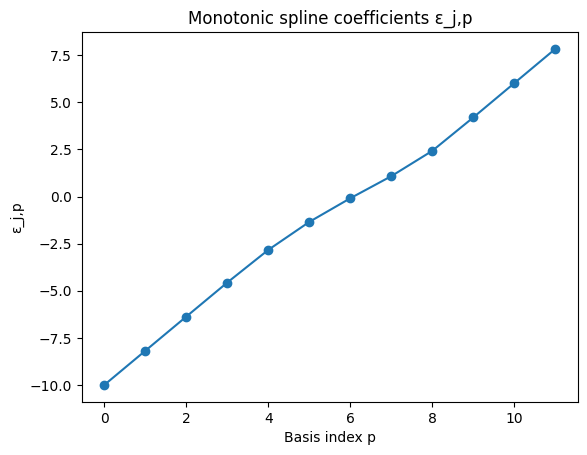

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.2510, -8.0944, -6.0777, -4.4967, -3.0100, -1.5742, -0.2697,  0.8888,
         1.9175,  2.8651,  3.8051,  4.7467])


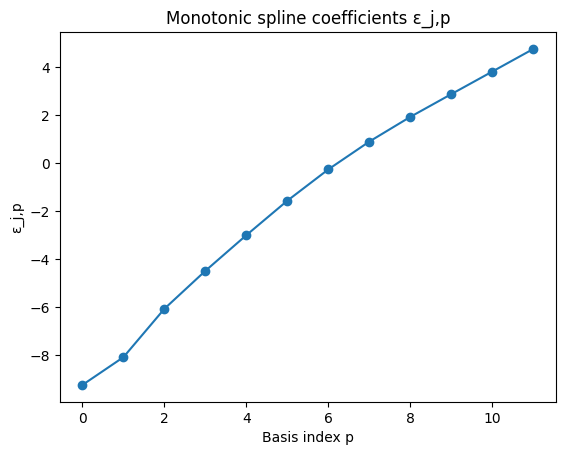

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.3289,  -8.7368,  -7.1448,  -5.5528,  -3.9391,  -0.8191,   3.3572,
          5.3258,   7.1440,   8.9622,  10.7804,  12.5985])


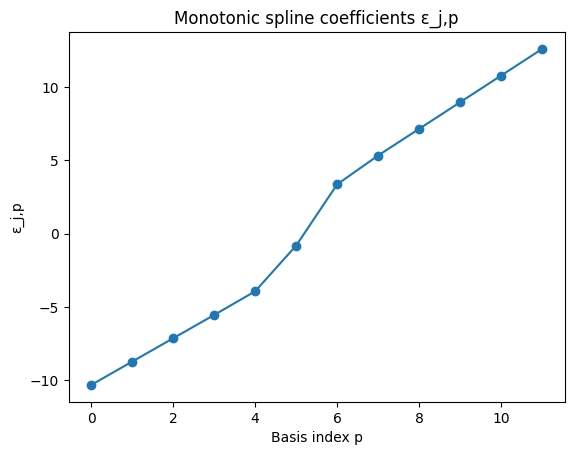

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.0444, -7.9786, -5.6910, -4.3110, -2.9569, -0.5735,  2.0076,  3.0012,
         3.9317,  4.8653,  5.7879,  6.7022])


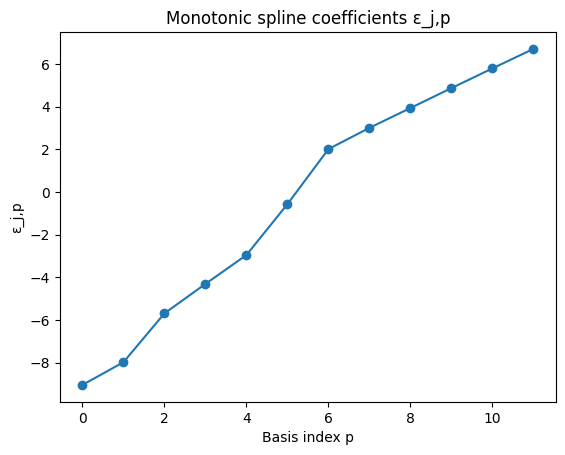

In [20]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

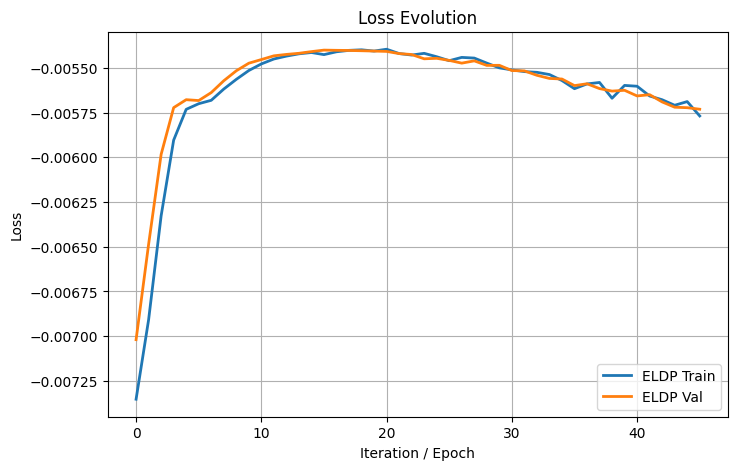

In [21]:
loss_history = output['ll_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Train", linewidth=2)
plt.plot(val_loss, label="ELDP Val", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [23]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [24]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.171
KLD GTM      Train Data:  0.0111
KLD Gaussian Train Data:  -0.002
KLD Copula   Train Data:  -0.0008

KLD BGTM      Test  Data:  0.1544
KLD GTM      Test  Data:  0.0118
KLD Gaussian Test  Data:  0.0016
KLD Copula   Test  Data:  0.0008


In [25]:
#model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1275: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


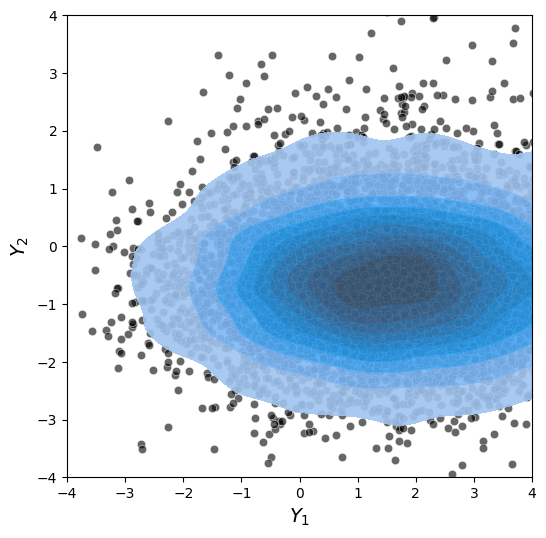

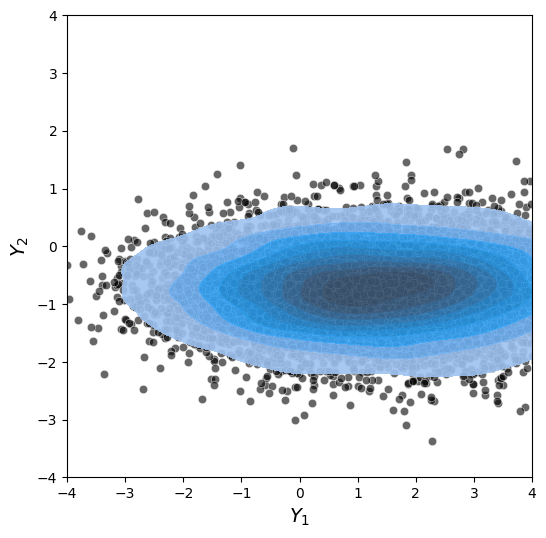

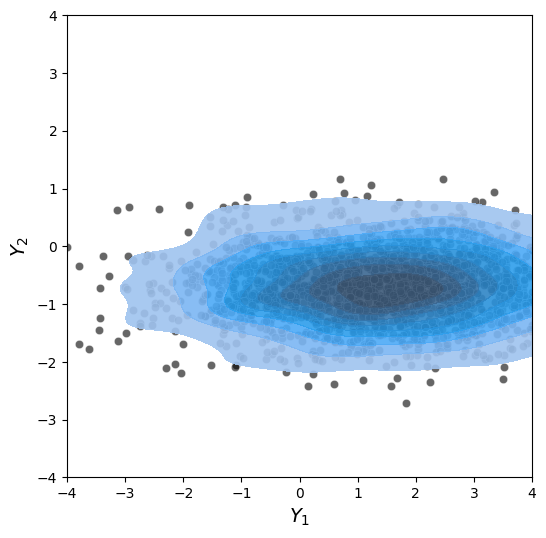

In [26]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

### Independence copula + two-component Gaussian mixture marginals (non-Gaussian)

In [27]:
import numpy as np
import torch
import pyvinecopulib as pv

# Mixture parameters per dimension (same weights across dims for simplicity)
w1 = 0.35  # w2 = 1 - w1
means = torch.tensor([[-2.0,  1.0],   # component 1 means per dim
                      [ 2.0, -1.0]],  # component 2 means per dim
                     dtype=torch.float32)
stds  = torch.tensor([[0.8, 0.5],
                      [0.6, 0.9]], dtype=torch.float32)

def gm2_icdf(u, w1, m, s):
    """
    u: [N, D] tensor in (0,1); w1 scalar; m,s: shape [2, D]
    Returns x: [N, D]
    """
    w2 = 1.0 - w1
    x = torch.empty_like(u)
    mask1 = (u < w1)
    u1 = torch.where(mask1, u / w1, torch.tensor(0.5, dtype=u.dtype))
    u2 = torch.where(~mask1, (u - w1) / w2, torch.tensor(0.5, dtype=u.dtype))
    # invert per dim
    for d in range(u.shape[1]):
        x1 = torch.distributions.Normal(m[0, d], s[0, d]).icdf(u1[:, d])
        x2 = torch.distributions.Normal(m[1, d], s[1, d]).icdf(u2[:, d])
        x[:, d] = torch.where(mask1[:, d], x1, x2)
    return x

def gm2_logpdf(x, w1, m, s):
    w2 = 1.0 - w1
    lp = torch.zeros(x.shape[0])
    for d in range(x.shape[1]):
        lp1 = torch.distributions.Normal(m[0, d], s[0, d]).log_prob(x[:, d])
        lp2 = torch.distributions.Normal(m[1, d], s[1, d]).log_prob(x[:, d])
        # log( w1*e^lp1 + w2*e^lp2 )
        a = torch.stack([lp1 + np.log(w1), lp2 + np.log(w2)], dim=1)
        lp += torch.logsumexp(a, dim=1)
    return lp

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
U_train = torch.tensor(simulated_data_uniform_train).float()
simulated_data_train = gm2_icdf(U_train, w1, means, stds)

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
U_val = torch.tensor(simulated_data_uniform_validate).float()
simulated_data_validate = gm2_icdf(U_val, w1, means, stds)

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
U_test = torch.tensor(simulated_data_uniform_test).float()
simulated_data_test = gm2_icdf(U_test, w1, means, stds)

# ---------- "True" log-likelihoods under independence + GM(2) marginals ----------
loglik_true_train = gm2_logpdf(simulated_data_train, w1, means, stds)
loglik_true_validate = gm2_logpdf(simulated_data_validate, w1, means, stds)
loglik_true_test = gm2_logpdf(simulated_data_test, w1, means, stds)

# ---------- (Optional) crude "estimated" marginals ----------
# For mixtures, proper estimation needs EM or VI. If you just want a baseline,
# you could (very crudely) fit a single Gaussian to each dim:
means_est = simulated_data_train.mean(0)
stds_est  = simulated_data_train.std(0, unbiased=True)
loglik_true_est_train = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_test).sum(1)
# (Use only as a rough reference; your transformation layer should beat this.)


In [28]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=50)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=50)

# BGTM

In [29]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 10,  # try 5–10
                #Optimization method
                beta_kl_start= 1.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 15,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=50  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:04<14:12,  4.28s/it]

IMPROVED! Congrats
[1/200] ELBO train=379.9236  val_ELPD=-0.0409  train_ELPD=-0.0412  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈-1.89e+04  tau4=0.647868  rank=20  E_qf_mean≈17.1  E_qf_total≈34.3  tau*E_qf≈22.2  target≈22.2  resid≈-1.88e+04  Δ=-1.10e+03   β_KL=1.50  


  1%|          | 2/200 [00:08<13:45,  4.17s/it]

IMPROVED! Congrats
[2/200] ELBO train=3.0579  val_ELPD=-0.0372  train_ELPD=-0.0387  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈-19.8  tau4=0.744507  rank=20  E_qf_mean≈14.9  E_qf_total≈29.8  tau*E_qf≈22.2  target≈22.2  resid≈1.44  Δ=+9.66e-02   β_KL=1.47  


  2%|▏         | 3/200 [00:12<13:33,  4.13s/it]

IMPROVED! Congrats
[3/200] ELBO train=2.9198  val_ELPD=-0.0363  train_ELPD=-0.0368  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈-17.7  tau4=0.792276  rank=20  E_qf_mean≈14  E_qf_total≈28  tau*E_qf≈22.2  target≈22.2  resid≈0.669  Δ=+4.78e-02   β_KL=1.43  


  2%|▏         | 4/200 [00:16<13:25,  4.11s/it]

IMPROVED! Congrats
[4/200] ELBO train=2.7959  val_ELPD=-0.0358  train_ELPD=-0.0360  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈-14.4  tau4=0.797701  rank=20  E_qf_mean≈13.1  E_qf_total≈26.2  tau*E_qf≈20.9  target≈22.2  resid≈0.711  Δ=+5.42e-03   β_KL=1.40  


  2%|▎         | 5/200 [00:20<13:17,  4.09s/it]

IMPROVED! Congrats
[5/200] ELBO train=2.6505  val_ELPD=-0.0356  train_ELPD=-0.0357  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈-10  tau4=0.819556  rank=20  E_qf_mean≈12.2  E_qf_total≈24.5  tau*E_qf≈20.1  target≈22.2  resid≈1.34  Δ=+2.19e-02   β_KL=1.37  


  3%|▎         | 6/200 [00:24<13:23,  4.14s/it]

IMPROVED! Congrats
[6/200] ELBO train=2.5449  val_ELPD=-0.0355  train_ELPD=-0.0355  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈-5.54  tau4=0.849721  rank=20  E_qf_mean≈11.4  E_qf_total≈22.9  tau*E_qf≈19.4  target≈22.2  resid≈1.73  Δ=+3.02e-02   β_KL=1.33  


  4%|▎         | 7/200 [00:29<14:19,  4.45s/it]

IMPROVED! Congrats
[7/200] ELBO train=2.4232  val_ELPD=-0.0355  train_ELPD=-0.0355  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈-1.01  tau4=0.888367  rank=20  E_qf_mean≈10.6  E_qf_total≈21.3  tau*E_qf≈18.9  target≈22.2  resid≈2.06  Δ=+3.86e-02   β_KL=1.30  


  4%|▍         | 8/200 [00:34<13:59,  4.37s/it]

NOT IMPROVED! Nr. 1
[8/200] ELBO train=2.3020  val_ELPD=-0.0355  train_ELPD=-0.0355  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈3.52  tau4=0.93692  rank=20  E_qf_mean≈9.81  E_qf_total≈19.6  tau*E_qf≈18.4  target≈22.2  resid≈2.38  Δ=+4.86e-02   β_KL=1.27  


  4%|▍         | 9/200 [00:38<13:40,  4.29s/it]

NOT IMPROVED! Nr. 2
[9/200] ELBO train=2.2092  val_ELPD=-0.0356  train_ELPD=-0.0355  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈8.02  tau4=0.997126  rank=20  E_qf_mean≈8.97  E_qf_total≈17.9  tau*E_qf≈17.9  target≈22.2  resid≈2.7  Δ=+6.02e-02   β_KL=1.23  


  5%|▌         | 10/200 [00:42<13:25,  4.24s/it]

NOT IMPROVED! Nr. 3
[10/200] ELBO train=2.0844  val_ELPD=-0.0357  train_ELPD=-0.0356  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈12.5  tau4=1.07015  rank=20  E_qf_mean≈8.15  E_qf_total≈16.3  tau*E_qf≈17.4  target≈22.2  resid≈2.98  Δ=+7.30e-02   β_KL=1.20  


  6%|▌         | 11/200 [00:46<13:11,  4.19s/it]

NOT IMPROVED! Nr. 4
[11/200] ELBO train=1.9344  val_ELPD=-0.0359  train_ELPD=-0.0358  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0602 σmin=0.0601 σmax=0.0603  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈16.5  tau4=1.15458  rank=20  E_qf_mean≈7.44  E_qf_total≈14.9  tau*E_qf≈17.2  target≈22.2  resid≈3.14  Δ=+8.44e-02   β_KL=1.17  


  6%|▌         | 12/200 [00:50<13:02,  4.16s/it]

NOT IMPROVED! Nr. 5
[12/200] ELBO train=1.7487  val_ELPD=-0.0361  train_ELPD=-0.0361  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0725 σmin=0.0721 σmax=0.0727  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈20  tau4=1.24735  rank=20  E_qf_mean≈6.86  E_qf_total≈13.7  tau*E_qf≈17.1  target≈22.2  resid≈3.18  Δ=+9.28e-02   β_KL=1.13  


  6%|▋         | 13/200 [00:54<12:54,  4.14s/it]

NOT IMPROVED! Nr. 6
[13/200] ELBO train=1.5801  val_ELPD=-0.0364  train_ELPD=-0.0363  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0870 σmin=0.0861 σmax=0.0873  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈23.5  tau4=1.34656  rank=20  E_qf_mean≈6.37  E_qf_total≈12.7  tau*E_qf≈17.1  target≈22.2  resid≈3.16  Δ=+9.92e-02   β_KL=1.10  


  7%|▋         | 14/200 [00:58<12:44,  4.11s/it]

NOT IMPROVED! Nr. 7
[14/200] ELBO train=1.3986  val_ELPD=-0.0368  train_ELPD=-0.0367  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.1039 σmin=0.1018 σmax=0.1047  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈27  tau4=1.44644  rank=20  E_qf_mean≈6.01  E_qf_total≈12  tau*E_qf≈17.4  target≈22.2  resid≈3  Δ=+9.99e-02   β_KL=1.07  


  8%|▊         | 15/200 [01:02<12:39,  4.10s/it]

NOT IMPROVED! Nr. 8
[15/200] ELBO train=1.2619  val_ELPD=-0.0371  train_ELPD=-0.0370  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.1234 σmin=0.1197 σmax=0.1252  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈30.5  tau4=1.53849  rank=20  E_qf_mean≈5.82  E_qf_total≈11.6  tau*E_qf≈17.9  target≈22.2  resid≈2.68  Δ=+9.21e-02   β_KL=1.03  


  8%|▊         | 16/200 [01:06<12:31,  4.09s/it]

NOT IMPROVED! Nr. 9
[16/200] ELBO train=1.1136  val_ELPD=-0.0374  train_ELPD=-0.0374  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1451 σmin=0.1372 σmax=0.1490  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈33.9  tau4=1.61481  rank=20  E_qf_mean≈5.78  E_qf_total≈11.6  tau*E_qf≈18.7  target≈22.2  resid≈2.21  Δ=+7.63e-02   β_KL=1.00  


  8%|▊         | 17/200 [01:10<12:29,  4.09s/it]

NOT IMPROVED! Nr. 10
[17/200] ELBO train=0.9965  val_ELPD=-0.0377  train_ELPD=-0.0377  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1618 σmin=0.1470 σmax=0.1684  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈36.6  tau4=1.67398  rank=20  E_qf_mean≈5.81  E_qf_total≈11.6  tau*E_qf≈19.4  target≈22.2  resid≈1.72  Δ=+5.92e-02   β_KL=1.00  


  9%|▉         | 18/200 [01:14<12:21,  4.08s/it]

NOT IMPROVED! Nr. 11
[18/200] ELBO train=0.9186  val_ELPD=-0.0378  train_ELPD=-0.0380  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1795 σmin=0.1571 σmax=0.1900  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈38.8  tau4=1.72057  rank=20  E_qf_mean≈5.82  E_qf_total≈11.6  tau*E_qf≈20  target≈22.2  resid≈1.36  Δ=+4.66e-02   β_KL=1.00  


 10%|▉         | 19/200 [01:18<12:14,  4.06s/it]

NOT IMPROVED! Nr. 12
[19/200] ELBO train=0.8290  val_ELPD=-0.0381  train_ELPD=-0.0381  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1987 σmin=0.1671 σmax=0.2140  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈40.9  tau4=1.7562  rank=20  E_qf_mean≈5.85  E_qf_total≈11.7  tau*E_qf≈20.5  target≈22.2  resid≈1.04  Δ=+3.56e-02   β_KL=1.00  


 10%|█         | 20/200 [01:23<12:09,  4.05s/it]

NOT IMPROVED! Nr. 13
[20/200] ELBO train=0.7574  val_ELPD=-0.0384  train_ELPD=-0.0384  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.2191 σmin=0.1755 σmax=0.2406  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈43  tau4=1.7694  rank=20  E_qf_mean≈5.88  E_qf_total≈11.8  tau*E_qf≈20.8  target≈22.2  resid≈0.776  Δ=+1.32e-02   β_KL=1.00  


 10%|█         | 21/200 [01:27<12:04,  4.05s/it]

NOT IMPROVED! Nr. 14
[21/200] ELBO train=0.6662  val_ELPD=-0.0385  train_ELPD=-0.0384  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.2400 σmin=0.1836 σmax=0.2694  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈45.2  tau4=1.77949  rank=20  E_qf_mean≈5.93  E_qf_total≈11.9  tau*E_qf≈21.1  target≈22.2  resid≈0.599  Δ=+1.01e-02   β_KL=1.00  


 11%|█         | 22/200 [01:31<11:59,  4.04s/it]

NOT IMPROVED! Nr. 15
[22/200] ELBO train=0.6020  val_ELPD=-0.0387  train_ELPD=-0.0391  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.2604 σmin=0.1936 σmax=0.3000  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈47.3  tau4=1.78618  rank=20  E_qf_mean≈6.01  E_qf_total≈12  tau*E_qf≈21.5  target≈22.2  resid≈0.402  Δ=+6.69e-03   β_KL=1.00  


 12%|█▏        | 23/200 [01:35<11:56,  4.05s/it]

NOT IMPROVED! Nr. 16
[23/200] ELBO train=0.5171  val_ELPD=-0.0390  train_ELPD=-0.0388  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.2819 σmin=0.1972 σmax=0.3338  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈49.4  tau4=1.78988  rank=20  E_qf_mean≈6.09  E_qf_total≈12.2  tau*E_qf≈21.8  target≈22.2  resid≈0.225  Δ=+3.70e-03   β_KL=1.00  


 12%|█▏        | 24/200 [01:39<11:51,  4.04s/it]

NOT IMPROVED! Nr. 17
[24/200] ELBO train=0.4568  val_ELPD=-0.0390  train_ELPD=-0.0391  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.3040 σmin=0.2030 σmax=0.3701  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈51.3  tau4=1.78816  rank=20  E_qf_mean≈6.26  E_qf_total≈12.5  tau*E_qf≈22.4  target≈22.2  resid≈-0.108  Δ=-1.72e-03   β_KL=1.00  


 12%|█▎        | 25/200 [01:43<11:46,  4.04s/it]

NOT IMPROVED! Nr. 18
[25/200] ELBO train=0.3817  val_ELPD=-0.0392  train_ELPD=-0.0391  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.3273 σmin=0.2139 σmax=0.4097  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈53.4  tau4=1.78407  rank=20  E_qf_mean≈6.35  E_qf_total≈12.7  tau*E_qf≈22.7  target≈22.2  resid≈-0.26  Δ=-4.09e-03   β_KL=1.00  


 13%|█▎        | 26/200 [01:47<11:43,  4.04s/it]

NOT IMPROVED! Nr. 19
[26/200] ELBO train=0.3288  val_ELPD=-0.0393  train_ELPD=-0.0394  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3489 σmin=0.2205 σmax=0.4497  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈55.6  tau4=1.77837  rank=20  E_qf_mean≈6.43  E_qf_total≈12.9  tau*E_qf≈22.9  target≈22.2  resid≈-0.367  Δ=-5.70e-03   β_KL=1.00  


 14%|█▎        | 27/200 [01:51<11:48,  4.09s/it]

NOT IMPROVED! Nr. 20
[27/200] ELBO train=0.2844  val_ELPD=-0.0396  train_ELPD=-0.0396  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3646 σmin=0.2203 σmax=0.4795  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈57.3  tau4=1.77022  rank=20  E_qf_mean≈6.54  E_qf_total≈13.1  tau*E_qf≈23.2  target≈22.2  resid≈-0.533  Δ=-8.14e-03   β_KL=1.00  


 14%|█▍        | 28/200 [01:55<11:41,  4.08s/it]

NOT IMPROVED! Nr. 21
[28/200] ELBO train=0.2283  val_ELPD=-0.0396  train_ELPD=-0.0396  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3795 σmin=0.2145 σmax=0.5102  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈58.6  tau4=1.75711  rank=20  E_qf_mean≈6.77  E_qf_total≈13.5  tau*E_qf≈23.8  target≈22.2  resid≈-0.888  Δ=-1.31e-02   β_KL=1.00  


 14%|█▍        | 29/200 [01:59<11:35,  4.07s/it]

NOT IMPROVED! Nr. 22
[29/200] ELBO train=0.1951  val_ELPD=-0.0396  train_ELPD=-0.0397  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3949 σmin=0.2148 σmax=0.5426  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈60  tau4=1.72586  rank=20  E_qf_mean≈6.93  E_qf_total≈13.9  tau*E_qf≈23.9  target≈22.2  resid≈-1.08  Δ=-3.12e-02   β_KL=1.00  


 15%|█▌        | 30/200 [02:03<11:29,  4.06s/it]

NOT IMPROVED! Nr. 23
[30/200] ELBO train=0.1458  val_ELPD=-0.0396  train_ELPD=-0.0399  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.4097 σmin=0.2165 σmax=0.5769  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈61.7  tau4=1.6954  rank=20  E_qf_mean≈7.05  E_qf_total≈14.1  tau*E_qf≈23.9  target≈22.2  resid≈-1.07  Δ=-3.05e-02   β_KL=1.00  


 16%|█▌        | 31/200 [02:07<11:24,  4.05s/it]

NOT IMPROVED! Nr. 24
[31/200] ELBO train=0.1201  val_ELPD=-0.0398  train_ELPD=-0.0403  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.4235 σmin=0.2162 σmax=0.6129  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈63.2  tau4=1.6636  rank=20  E_qf_mean≈7.22  E_qf_total≈14.4  tau*E_qf≈24  target≈22.2  resid≈-1.15  Δ=-3.18e-02   β_KL=1.00  


 16%|█▌        | 32/200 [02:11<11:19,  4.05s/it]

NOT IMPROVED! Nr. 25
[32/200] ELBO train=0.0551  val_ELPD=-0.0396  train_ELPD=-0.0396  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.4383 σmin=0.2118 σmax=0.6499  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈64.5  tau4=1.62533  rank=20  E_qf_mean≈7.54  E_qf_total≈15.1  tau*E_qf≈24.5  target≈22.2  resid≈-1.44  Δ=-3.83e-02   β_KL=1.00  


 16%|█▋        | 33/200 [02:15<11:16,  4.05s/it]

NOT IMPROVED! Nr. 26
[33/200] ELBO train=0.0226  val_ELPD=-0.0397  train_ELPD=-0.0401  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.4519 σmin=0.2123 σmax=0.6858  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈65.9  tau4=1.58199  rank=20  E_qf_mean≈7.88  E_qf_total≈15.8  tau*E_qf≈24.9  target≈22.2  resid≈-1.71  Δ=-4.33e-02   β_KL=1.00  


 17%|█▋        | 34/200 [02:19<11:11,  4.04s/it]

NOT IMPROVED! Nr. 27
[34/200] ELBO train=-0.0334  val_ELPD=-0.0397  train_ELPD=-0.0397  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.4665 σmin=0.2141 σmax=0.7217  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈67.4  tau4=1.53724  rank=20  E_qf_mean≈8.17  E_qf_total≈16.3  tau*E_qf≈25.1  target≈22.2  resid≈-1.83  Δ=-4.47e-02   β_KL=1.00  


 18%|█▊        | 35/200 [02:23<11:06,  4.04s/it]

NOT IMPROVED! Nr. 28
[35/200] ELBO train=-0.0385  val_ELPD=-0.0398  train_ELPD=-0.0405  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.4782 σmin=0.2154 σmax=0.7578  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈69.1  tau4=1.49327  rank=20  E_qf_mean≈8.42  E_qf_total≈16.8  tau*E_qf≈25.2  target≈22.2  resid≈-1.85  Δ=-4.40e-02   β_KL=1.00  


 18%|█▊        | 36/200 [02:27<11:02,  4.04s/it]

NOT IMPROVED! Nr. 29
[36/200] ELBO train=-0.1044  val_ELPD=-0.0396  train_ELPD=-0.0402  S_train=4 S_val=16  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.4909 σmin=0.2153 σmax=0.7964  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈70.7  tau4=1.44814  rank=20  E_qf_mean≈8.76  E_qf_total≈17.5  tau*E_qf≈25.4  target≈22.2  resid≈-1.98  Δ=-4.51e-02   β_KL=1.00  


 18%|█▊        | 36/200 [02:31<11:31,  4.22s/it]

NOT IMPROVED! Nr. 30
[37/200] ELBO train=-0.1418  val_ELPD=-0.0396  train_ELPD=-0.0401  S_train=4 S_val=16  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.5001 σmin=0.2193 σmax=0.8242  N=2000 B=50 B̄≈50.0  priors/obs: decor≈0 trans≈72.2  tau4=1.40544  rank=20  E_qf_mean≈8.99  E_qf_total≈18  tau*E_qf≈25.3  target≈22.2  resid≈-1.92  Δ=-4.27e-02   β_KL=1.00  
Early stop @ epoch 37: no val improvement for 30 epochs.


# GTM

In [30]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(2.2021, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1054, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8174,

  0%|          | 1/1000 [00:00<11:37,  1.43it/s]

current_loss: tensor(1.7816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7784, grad_fn=<MeanBackward0>)
current_loss: tensor(156.1077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.798

  0%|          | 2/1000 [00:01<11:47,  1.41it/s]

current_loss: tensor(1.7519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6963,

  0%|          | 3/1000 [00:02<11:44,  1.42it/s]

tensor(1.7612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7800, grad_fn=<Mean

  0%|          | 4/1000 [00:02<11:43,  1.42it/s]

current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8193,

  0%|          | 5/1000 [00:03<11:29,  1.44it/s]

current_loss: tensor(1.7717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7104,

  1%|          | 6/1000 [00:04<11:31,  1.44it/s]

current_loss: tensor(2.0527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7177,

  1%|          | 7/1000 [00:04<11:32,  1.43it/s]

current_loss: tensor(1.7693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6642,

  1%|          | 7/1000 [00:05<13:12,  1.25it/s]

current_loss: tensor(1.7461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7430, grad_fn=<MeanBackward0>)
Early Stop at iteration 7 with minimal loss tensor(1.7374, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.7355, -7.7395, -5.7434, -3.7493, -1.6764, -0.5723, -0.2940,  1.7431,
         3.8691,  5.6874,  7.5056,  9.3238])


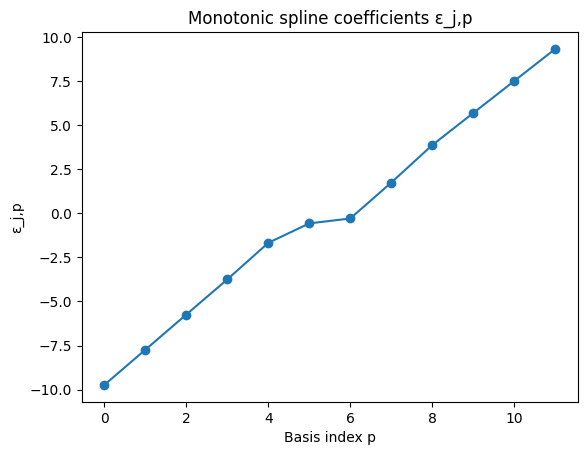

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.4586, -7.8183, -5.2737, -3.2711, -1.5197, -0.6591, -0.2732,  1.9027,
         2.2145,  2.3448,  2.4730,  2.6072])


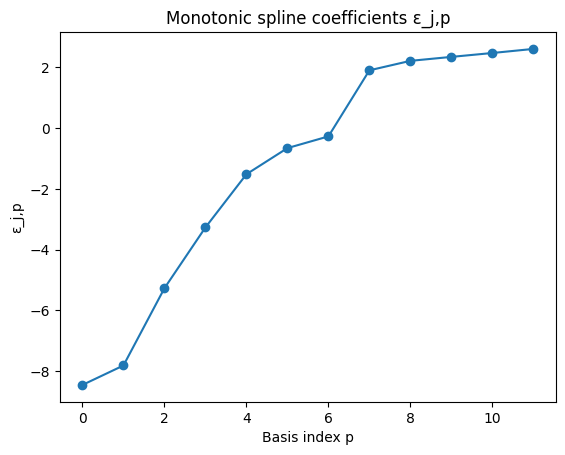

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9350, -8.0752, -6.2155, -4.3558, -2.4529, -0.6000,  1.0159,  3.2203,
         5.0501,  6.8683,  8.6865, 10.5047])


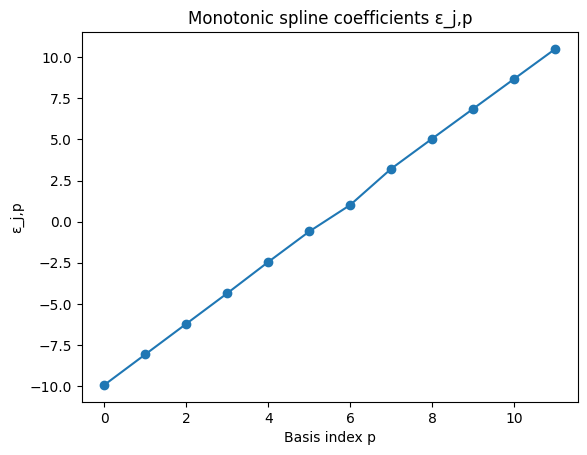

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.5775, -7.9987, -5.6927, -3.9022, -2.3356, -0.6194,  0.9707,  2.7890,
         3.0367,  3.1827,  3.3273,  3.4741])


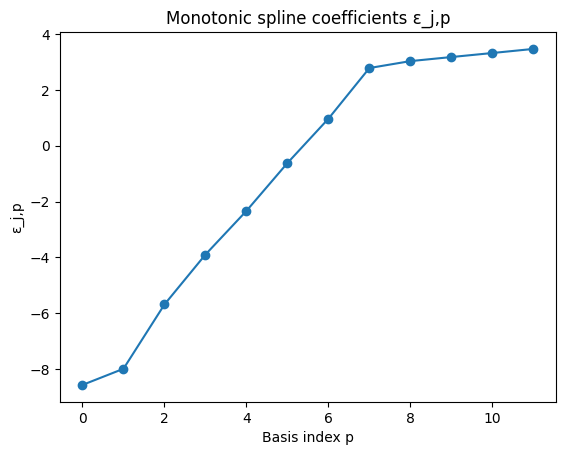

In [31]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

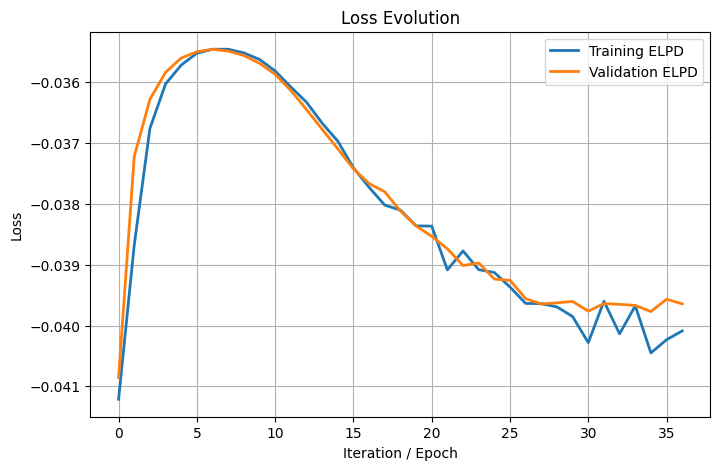

In [32]:
loss_history = output['ll_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Training ELPD", linewidth=2)
plt.plot(val_loss, label="Validation ELPD", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [34]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
#print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
#print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.3131
KLD GTM      Train Data:  0.2252
KLD Copula   Train Data:  0.542

KLD BGTM      Test  Data:  0.3201
KLD GTM      Test  Data:  0.2306
KLD Copula   Test  Data:  0.5441


In [41]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

RuntimeError: index 101 is out of bounds for dimension 2 with size 101

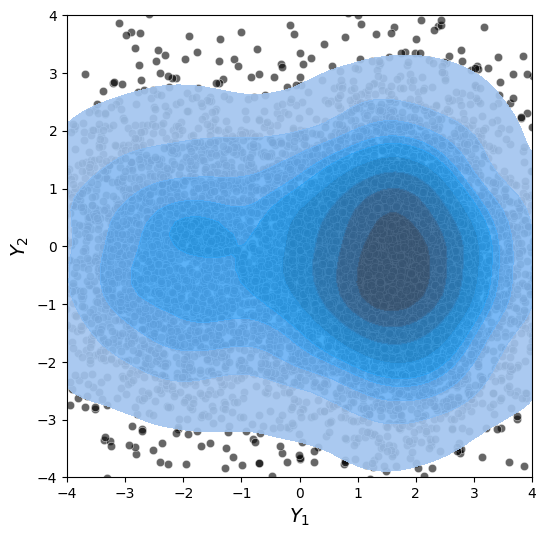

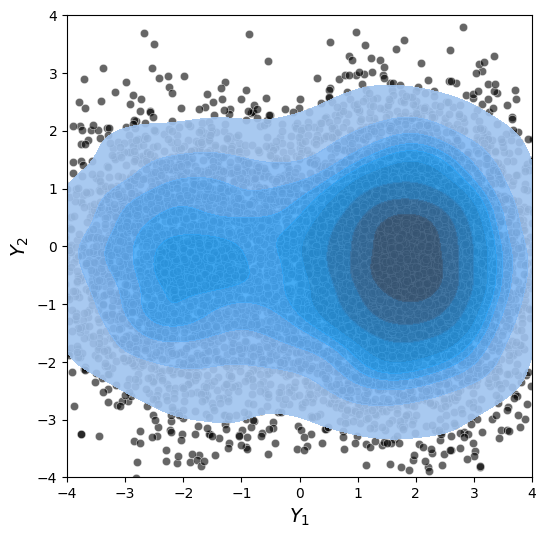

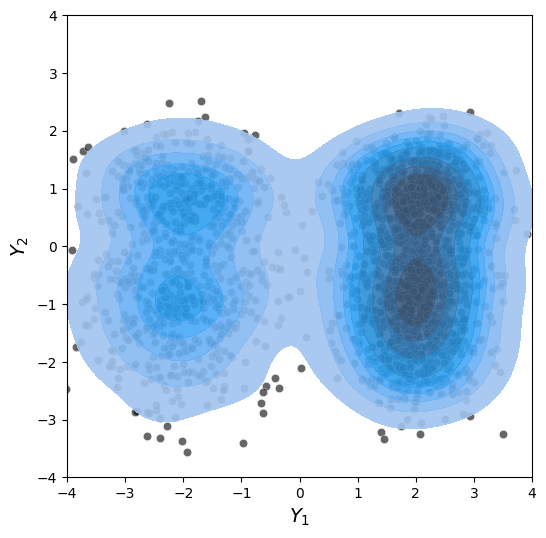

In [ ]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])